# Normal distribution 

The simplest model: the Normal distribution. It is used as a basic components in many more complex models.

In [1]:
using Pkg
Pkg.activate("../");

using LinearAlgebra
using Plots
using ExpFamilyDistributions
using Random

using Revise
using BayesianModels

using BasicDataLoaders

# Plotting function
include("plotting.jl");

 Activating environment at `~/GithubRepositories/PPCA/Project.toml`
┌ Info: Precompiling BayesianModels [1400088c-90aa-43b9-ae43-7211fec07595]
└ @ Base loading.jl:1278


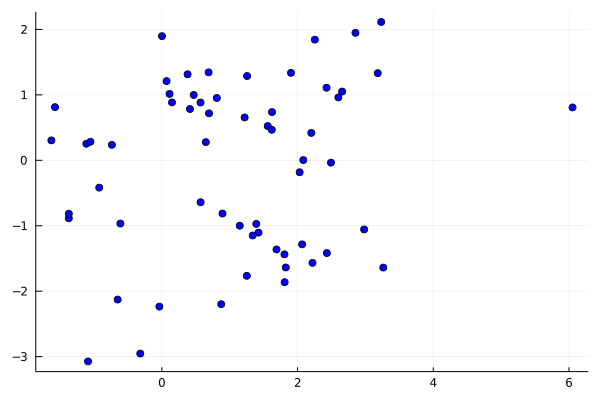

In [2]:
Random.seed!(100)

T = Float64

μ₁ = T[1, 1] 
Σ₁ = T[2. 0; 0  0.3]

μ₂ = T[-1, -1] 
Σ₂ = T[0.3 0; 0  2]

μ₃ = T[2, -1] 
Σ₃ = T[0.5 0; 0  0.5]

function draw(n, μ, Σ)
    L = cholesky(Σ).L
    [μ + L*randn(T, 2) for i in 1:n] 
end

X₁ = draw(30, μ₁, Σ₁)
X₂ = draw(10, μ₂, Σ₂)
X₃ = draw(20, μ₃, Σ₃)

scatter(getindex.(X₁, 1), getindex.(X₁, 2), color = :blue, legend = false)
scatter!(getindex.(X₂, 1), getindex.(X₂, 2), color = :blue)
scatter!(getindex.(X₃, 1), getindex.(X₃, 2), color = :blue)

In [8]:
K = 5
normals = [BayesianModels.NormalDiag(datadim = 2, pstrength = 1) for i in 1:K]
Mixture(components = normals)

Mixture{BayesianModels.NormalDiag{Float64,2},5}:
  π: BayesParam{Dirichlet{Float64,5},Dirichlet{Float64,5}}
  components: NTuple{5,BayesianModels.NormalDiag{Float64,2}}


In [2]:
lrate = 0.1
epochs = 100
batchsize = 10

elbos = [elbo(model, dl)]

for epoch in 1:epochs
    
    dl = DataLoader(shuffle(vcat(X₁, X₂, X₃)), batchsize = batchsize)
    for batch in dl
        scale = length(dl)
    
        # Gradient update 
        for (param, ∇L) in ∇elbo(model, batch, stats_scale = scale)
            η = naturalparam(param.posterior) + lrate*∇L
            update!(param.posterior, η)
        end
    end
    
    push!(elbos, elbo(model, dl))
end

plot(elbos)

LoadError: UndefVarError: model not defined

In [124]:
gradlognorm(model.μ.posterior)

4-element Array{Float64,1}:
  0.9318407519512345
 -0.26634512435207114
  1.113186145694532
  0.30142776935396803

In [26]:
s = μstats(model, dl[1])
#vcat(getindex.(s, 1), getindex.(s, 2))

4-element Array{Float64,1}:
 11.914475966940637
 13.037394088780065
 -5.0
 -5.0

In [31]:
getparam_stats(model, dl[1])

Dict{BayesParam,Array{T,1} where T} with 3 entries:
  BayesParam{Gamma{Float64},Gamma{Float64}}(G… => [-18.6419, 5.0]
  BayesParam{NormalDiag{Float64,2},NormalDiag… => [11.9145, 13.0374, -5.0, -5.0]
  BayesParam{Gamma{Float64},Gamma{Float64}}(G… => [-15.0381, 5.0]

In [35]:
function monitor(epoch)
    𝓛 = elbo(model, X)
    println("epoch: $epoch 𝓛 = $𝓛")
end

fit!(model, dl, epochs = 100, callback = monitor)

LoadError: MethodError: no method matching fit!(::PPCAModel{Float64,2,2}, ::DataLoader{Array{Array{Float64,1},1}}; epochs=100, batchsize=10, callback=monitor)
Closest candidates are:
  fit!(::PPCAModel, ::Any; epochs, callback) at /home/lucas/GithubRepositories/PPCA/src/model.jl:158 got unsupported keyword argument "batchsize"

In [11]:
PPCA.loglikelihood(model, X)

30-element Array{Float64,1}:
  -998.6404479602035
  -998.4621610503211
 -1001.8006250143707
  -998.8292172894928
  -999.0388160456082
  -998.3844609138455
  -999.887519530657
  -998.4372970178565
  -998.3582787403415
 -1000.9523938435913
  -998.3451851159278
  -998.554859978746
  -998.4286497661419
     ⋮
  -998.53158655683
 -1000.5232306640667
  -998.8510404758227
  -999.3276218444682
  -998.5688155314732
 -1000.5135499400864
 -1000.0895730665771
  -998.2224783896842
  -998.9202914117858
  -999.6961460781422
  -999.3529721168882
 -1013.0458694873977